In [12]:
# The ingestion.py script that prepares the data
from ingestion import make_cleaned, make_train_test
# The metadata_helpers.py script saves our score & best parameter to csv / html
from metadata_helpers import save_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn and its friends
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.regressor import ResidualsPlot
from sklearn.metrics import mean_squared_error


In [3]:
# Prepare the gridsearch of hyperparameters
X_train, X_test, y_train, y_test = make_train_test()

categoric_cols = X_train.select_dtypes(include=object).columns.tolist()
std_scaler = SklearnTransformerWrapper(transformer=StandardScaler())
OH_encoder = SklearnTransformerWrapper(transformer=OneHotEncoder(
    sparse_output=False, drop='if_binary', min_frequency=0.1, handle_unknown='ignore'), variables=categoric_cols)
pipe = make_pipeline(std_scaler, OH_encoder, ElasticNet(max_iter=2000))
alpha_range = np.linspace(70, 150.0, num=20)
gs = GridSearchCV(n_jobs=3, estimator=pipe, cv=10, scoring='neg_root_mean_squared_error', param_grid={
                  'elasticnet__l1_ratio': [0.7, 0.8, 0.9, 1.0], 'elasticnet__alpha': alpha_range})


In [4]:
# Run the gridsearch
gs.fit(X_train, y_train)


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 26] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('sklearntransformerwrapper-1',
                                        SklearnTransformerWrapper(transformer=StandardScaler())),
                                       ('sklearntransformerwrapper-2',
                                        SklearnTransformerWrapper(transformer=OneHotEncoder(drop='if_binary',
                                                                                            handle_unknown='ignore',
                                                                                            min_frequency=0.1,
                                                                                            sparse_output=False),
                                                                  variables=['MSSubClass',
                                                                             'MSZoning',
                                                                             'Street',
                                                                             'Alley',
                                                                             'L...
             param_grid={'elasticnet__alpha': array([ 70.        ,  74.21052632,  78.42105263,  82.63157895,
        86.84210526,  91.05263158,  95.26315789,  99.47368421,
       103.68421053, 107.89473684, 112.10526316, 116.31578947,
       120.52631579, 124.73684211, 128.94736842, 133.15789474,
       137.36842105, 141.57894737, 145.78947368, 150.        ]),
                         'elasticnet__l1_ratio': [0.7, 0.8, 0.9, 1.0]},
             scoring='neg_root_mean_squared_error')

In [5]:
# View parameters searched
gs.param_grid


{'elasticnet__l1_ratio': [0.7, 0.8, 0.9, 1.0],
 'elasticnet__alpha': array([ 70.        ,  74.21052632,  78.42105263,  82.63157895,
         86.84210526,  91.05263158,  95.26315789,  99.47368421,
        103.68421053, 107.89473684, 112.10526316, 116.31578947,
        120.52631579, 124.73684211, 128.94736842, 133.15789474,
        137.36842105, 141.57894737, 145.78947368, 150.        ])}

In [6]:
# Parameters that optimized the CV score
gs.best_params_


{'elasticnet__alpha': 99.47368421052632, 'elasticnet__l1_ratio': 1.0}

/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 15, 25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/en

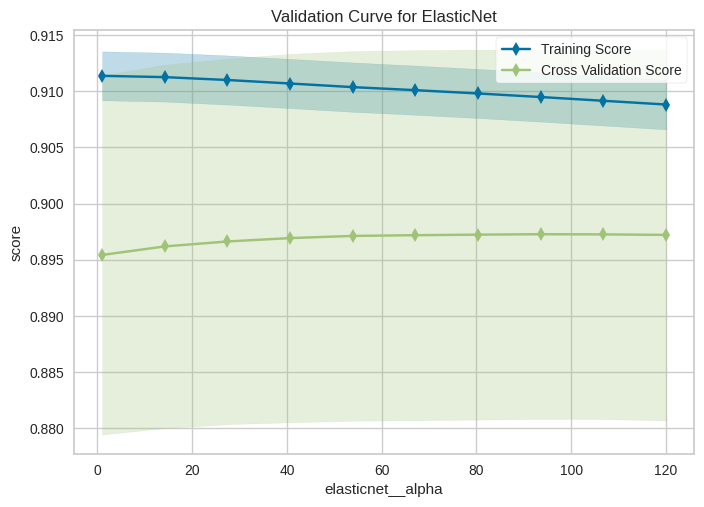

<AxesSubplot: title={'center': 'Validation Curve for ElasticNet'}, xlabel='elasticnet__alpha', ylabel='score'>

In [7]:
# Create validation curve to increase confidence that algorithm is performing reasonably
alpha_range = np.linspace(1, 120, num=10)
pipe_validation = make_pipeline(
    std_scaler, OH_encoder, ElasticNet(l1_ratio=1.0, max_iter=2000))
viz = ValidationCurve(
    pipe_validation, cv=10, param_name='elasticnet__alpha', param_range=alpha_range
)
# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.show()


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 11, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 11, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


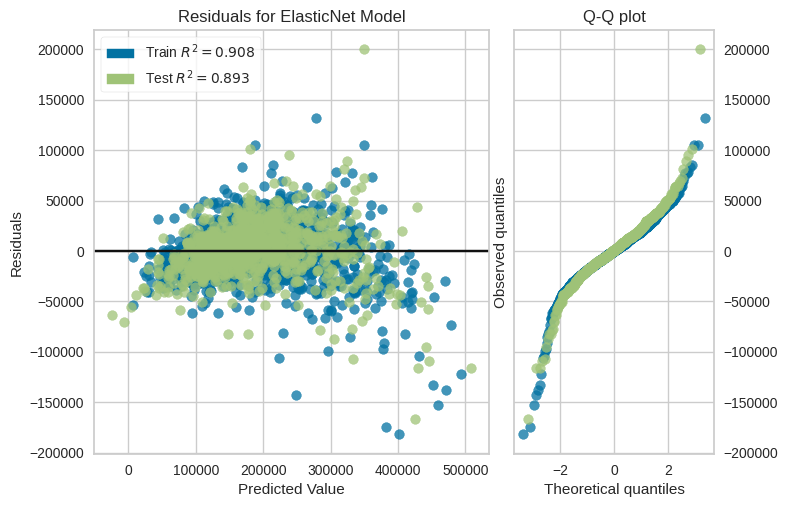

<AxesSubplot: title={'center': 'Residuals for ElasticNet Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [8]:
# Use best parameters from the gridsearch for our final model.
# Test the model on the holdout set (test set).
# Visualize the residuals.
pipe_final = make_pipeline(std_scaler, OH_encoder, ElasticNet(
    l1_ratio=1.0, max_iter=2000, alpha=99.47))
visualizer = ResidualsPlot(pipe_final, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


In [9]:
# Take a peek at the slopes (feature importances)
importances = list(zip(pipe_final._final_estimator.feature_names_in_,
                   pipe_final._final_estimator.coef_))
sorted(importances, key=lambda x: abs(x[1]), reverse=True)


[('GrLivArea', 27666.93923730124),
 ('OverallQual', 14710.36078243207),
 ('MasVnrType_BrkFace', -14092.400008074708),
 ('BldgType_infrequent_sklearn', -13978.386916190497),
 ('Functional_infrequent_sklearn', -13814.976171842889),
 ('MasVnrArea', 9662.871257870658),
 ('BsmtFinSF1', 9623.608827285037),
 ('SaleType_infrequent_sklearn', 8282.78966751611),
 ('YearBuilt', 7639.572070854546),
 ('Condition1_infrequent_sklearn', -7387.796213684062),
 ('ExterQual', 6129.1500000086435),
 ('TotalBsmtSF', 6046.902582522434),
 ('KitchenQual', 5402.229723627732),
 ('RoofStyle_Hip', 5379.669511517761),
 ('BedroomAbvGr', -5234.710907754713),
 ('Condition2_infrequent_sklearn', 5125.9679349402695),
 ('OverallCond', 4971.979425822338),
 ('Exterior1st_infrequent_sklearn', 4351.867752363824),
 ('GarageArea', 4282.01581780298),
 ('GarageFinish_RFn', -4274.174621829513),
 ('LandContour_infrequent_sklearn', 4033.1518270967513),
 ('BsmtQual', 3866.2661122806653),
 ('LotArea', 3474.749298740189),
 ('Exterior1st_

In [10]:
# Calculate our primary performance metric, the root mean squared deviation
# of the predictions from the true values in the test set.
rmse_test = mean_squared_error(
    pipe_final.predict(X_test), y_test, squared=False)
print(f"rmse = {rmse_test}")


rmse = 25841.183292942376


/home/bb/ames-housing/env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 11, 16, 17, 18] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [11]:
# Save the rmse and final model parameters to file scores.csv and scores.html.
# This is for organization and sanity during your process.
save_score(pipe_final, rmse_test)
